In [153]:
import os
import sys
import re
from operator import itemgetter
from datetime import datetime
from utils import split_text_at_punctuation
from langchain.document_loaders.text import TextLoader
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.chat_models.openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate, base, PromptTemplate
from langchain_core.output_parsers import PydanticOutputParser
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.pydantic_v1 import BaseModel, Field
from langchain.vectorstores import qdrant
from config import GPT_API
import re
from typing import Annotated, List, Dict, TypedDict
from langgraph.graph.message import add_messages, AnyMessage
from utils import check_latex_safety, validate_words
os.environ["OPENAI_API_KEY"] = GPT_API

current_date = datetime.now().strftime('%B%Y')


In [154]:
SET_TEMPERATURE = 0.2
MODEL = "gpt-4o-2024-05-13"#"gpt-3.5-turbo"

LLM_MODEL = ChatOpenAI(
    model=MODEL,
    name="Agent for job applications",
    temperature=SET_TEMPERATURE,
    n=1,
    )

In [155]:
# loader = TextLoader("ai_engineer_software_engineer.txt")

loader = DirectoryLoader(path="jobtemplates/")

load_applications = loader.load()

embedding_model = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-mpnet-base-v2",
    encode_kwargs = {'normalize_embeddings':False}
)

vectorstore = qdrant.Qdrant.from_documents(
    documents=load_applications,
    embedding=embedding_model,
    location=":memory:"
)

retriver = vectorstore.as_retriever(search_type="similarity",
                                    search_kwargs={'k': 1})

In [156]:
skills = [
    ##
    "Business analytics",
    "Business maturity",
    "Strategy",
    "Non-technical and technical communication",
    "Algorithms & datastrucures",
    "Software Engineering",
    "detail oriented",
    "Creative thinker",
    "Problem solving",
    "Critical thinking",
    "Team player",
    "Time management",
    "Adaptability",
    "Conflict resolution",
    "Collaborative",
    "Dilligent",
    "Software development",
    ## management
    "ITIL",
    "SAFe",
    "PRINCE2",
    "CMMI",
    "SCRUM",
    "Agile development",
    "UML(frequency, class or C4)",
    "Stakeholder classification",
    ## technical
    "Python intermediate level",
    "SQL working understanding",
    "R working understanding",
    "JavaScript working understanding",
    "Git"
    "Statistical modelling",
    "Fundamental Azure knowledge",
    "PostGres",
    "Neo4J",
    "Qdrant",
    "ANNOY",
    "Docker",
    "scraping",
    "crawling",
    "MT5",
    "Bert",
    "FinBert",
    "T5",
    "Scrapy",
    "Numpy",
    "Polars",
    "Pandas",
    "FastAPI",
    "VUE3",
    "TensorFlow2",
    "Hyggingface",
    "Pytorch",
    "SonarCube",
    "Seaborn(/matplotlib/Plotly)",
    "PyTest",
    "SKlearn"
    "Unsupervised learning: dimensionality reduction, explorative factor analysis, K-mean..",
    "Supervised learning: Random Forests, multiple logistic regression, SVP, NNs, Classification",
]


do_not_use_words = [
    "abreast",
    "ardent",
    "cruisal",
    "deeply",
    "eagerly",
    "endeavors",
    "enhance",
    "enhanced",
    "enhancing",
    "extensive",
    "extensively", 
    "expert",
    "expertise",
    "facets"
    "forefront",
    "fostering",
    "fueled",
    "fulfilling",
    "honed",
    "intricacies",
    "intricate",
    "meticulous ",
    "perfect",
    "perfectly",
    "prowess",
    "profoundly",
    "realm",
    "seamlessly",
    "specialist",
    "stems",
    "thrilled",
    "versed"
]


In [157]:
query_for_search = """
Engineering
In the platform area in Digital Architecture, Data and AI we lay the groundwork for other product teams to delivering accurate, available, and comprehensive data products to enable actionable insights. In addition to this we create trusted and curated enterprise data products that span the entire business of Vestas. This newly established department is an integral component of Vestas' innovative Digital Powerhouse. Our mission is to empower customers, partners, and colleagues to seamlessly discover, access, and connect essential information for informed decisions and impactful actions.
Digital Solutions & Development > Digital Solutions > Chapter - Data Engineering & Architecture
As a Data Engineer in the platform area, you will collaborate closely with colleagues both inside and outside of the platform area.
Your role involves leveraging a range of cloud technologies and tools tailored to the specific product you are working on. This encompasses working with technologies and tools such as Snowflake, databricks, dbt (data build tool) and Azure Services (storage accounts, key vaults).

Responsibilities
Your key responsibilities will be:
Designing, constructing, and maintaining scalable, reliable, and efficient data products
Managing and monitoring data products
Engaging in close collaboration with stakeholders who consume the data product
Establishing necessary integrations with various sources to enable data extraction
  
Qualifications 
Degree in Business Intelligence, Data Engineering or Software Development and/or 3 to 5 years of Professional work experience in a similar field
Comfortable in a dynamic and changeable working day
Comprehensive analytical and problem-solving skills
Advanced communication and collaboration skills, with the ability to work effectively in a cross-functional team environment
Proficient communication skills in English (our corporate language), Danish is not required
 
Competencies
We envision that you possess experience in designing, building, and maintaining data transformation logic. Furthermore, you may see yourself reflected in any of the following categories:
Proficiency in programming languages like SQL and Python - experience with dbt, spark, Airflow or Terraform is considered an asset
Experience in the development code in a team using devops techniques and agile development methodologies
Expertise in working with various Data Warehouse solutions and constructing data products using technologies such as Snowflake, Databricks, Azure Data Engineering Stack (like storage accounts, key vaults, Synapse, MSSQL, etc.)
Understanding of data warehouse modelling methodologies (Kimball, data vault et al.) as well as concepts like data mesh or similar
 
On a personal level, we anticipate that you:
Possess a collaborative and open-minded nature, eager to contribute to a globally diverse cross-functional team within the organization
Display curiosity and motivation for developing innovative data products that generate value exhibing positive communication skills, coupled with a positive, problem-solving approach to accomplishing tasks
Thrive in diverse environments and exhibit flexibility in adapting to evolving conditions embracing a commitment to continuous learning and a desire to contribute to the collective growth of the team
 
What we offer 

You will join a newly established, innovative, and committed team committed to support the business through the development of enterprise data products. You will also have the possibility to be part of forming how to best build data products. You will experience an environment that promotes continuous learning, enabling you to actualize your ambitions and get the chance to work in an agile office environment. While we hold our team members to high individual standards of collaboration, accountability, and meeting deadlines, we provide unwavering support to one another, collectively celebrating successes and addressing challenges.


"""


semilarity_document_template = vectorstore.similarity_search_with_score(
    query = query_for_search,
    k = 1,
    score_threshold=0.1)

# print("semilarity_document_template", semilarity_document_template)




In [158]:
## Vacancy analysis LLM
## Output data structure
class OutputStuctureV1(BaseModel):
    company_name: str = Field(description="identified company name")
    job_title: str = Field(description="identified job title")
    analysis_output: str = Field(description="analysis of the job vacancy")
    employees_skills_requirement: dict = Field(description="identified skills and technical experience required for the job vacancy")
    matching_skills: dict = Field(description="matching skills in the job vacancy")


parser = PydanticOutputParser(pydantic_object=OutputStuctureV1)

system_analysis_template_str = """
    You are an assisatant to a human resource manager//
    You are to assist in the analysis of a job vacancy//
    Identify vocal points of interest that the company is looking for//
    Identify the company name//
    Identify the job title//
    Identify the skills and technical experience required for the job vacancy provided here to be stored as a dictionary employee skill requirement//
    Use these skills {my_skills} to conduct an analysis between job requirements and find matching skills//
    Output should contain a list of matching skills required for the job vacancy//
    {format_messages}
    """


SYSTEM_ANALYSIS_PROMT = SystemMessagePromptTemplate(
    prompt = PromptTemplate(
        template=system_analysis_template_str,
        input_variables=["my_skills"],
        partical_variables={"format_instructions": parser.get_format_instructions()}
    )
)

human_analysis_template_str = """
    Given the job vacancy, you are to analyse the following in detail: {job_position}//
    {format_messages}
"""

HUMAN_ANALYSIS_PROMPT = HumanMessagePromptTemplate(
    prompt = PromptTemplate(
        template=human_analysis_template_str,
        input_variables=["job_position"],
        partical_variables={"format_messages": parser.get_format_instructions()}
    )

)

messages = [SYSTEM_ANALYSIS_PROMT, HUMAN_ANALYSIS_PROMPT]

analysis_review_template = ChatPromptTemplate(
    input_variables=["my_skills", "job_position"],
    messages=messages
)

pydantic_formatter = parser.get_format_instructions()

generate_analysis_of_job = analysis_review_template | LLM_MODEL | parser
analysis_review_template.format_messages(my_skills=skills, job_position=query_for_search, format_messages=pydantic_formatter)


analysis_chain = generate_analysis_of_job.invoke({"job_position":query_for_search, "my_skills":skills, "format_messages":pydantic_formatter})


In [159]:
for i in analysis_chain:
    print(i)


print("analysis_chain", analysis_chain)

('company_name', 'Vestas')
('job_title', 'Data Engineer')
('analysis_output', 'The job vacancy for a Data Engineer at Vestas requires a combination of technical and non-technical skills. The role involves designing, constructing, and maintaining data products using a variety of cloud technologies and tools. Key responsibilities include managing data products, collaborating with stakeholders, and establishing data integrations. The ideal candidate should have a degree in Business Intelligence, Data Engineering, or Software Development, or 3 to 5 years of professional experience in a similar field. Proficiency in SQL and Python, experience with dbt, Spark, Airflow, Terraform, and various Data Warehouse solutions are essential. Additionally, the candidate should possess strong analytical, problem-solving, communication, and collaboration skills.')
('employees_skills_requirement', {'Degree': 'Business Intelligence, Data Engineering, or Software Development', 'Experience': '3 to 5 years of 

In [152]:
# Extracting identified information from analysis_chain
identified_company_name = analysis_chain.company_name
identified_job_title = analysis_chain.job_title
identified_skill_requirements = analysis_chain.employees_skills_requirement
identified_matching_skills = analysis_chain.matching_skills
identified_analysis_output = analysis_chain.analysis_output

# Create the output dictionary according to the schema
output = {
    "company_name": identified_company_name,
    "job_title": identified_job_title,
    "analysis_output": identified_analysis_output,
    "employees_skills_requirement": identified_skill_requirements
}

# Getting keys from the dictionary
get_employee_requirements_keys = identified_skill_requirements.keys()

# Create an itemgetter object with these keys
get_employee_requirements_lists = itemgetter(*get_employee_requirements_keys)

# Applying itemgetter to the dictionary to get the lists
employee_requirements = get_employee_requirements_lists(identified_skill_requirements)

# Zipping keys with their corresponding lists
lists_with_employee_requirements = zip(get_employee_requirements_keys, employee_requirements)

# If you need to process lists_with_employee_requirements further, you can do so here
get_matching_skills_keys = identified_matching_skills.keys()
get_matching_skills_lists = itemgetter(*get_matching_skills_keys)
matching_skills = get_matching_skills_lists(identified_matching_skills)
lists_with_matching_skills = zip(get_matching_skills_keys, matching_skills)
# Example usage:
# print the output dictionary
print(list(lists_with_employee_requirements))
print(list(lists_with_matching_skills))





[('Degree', 'Business Intelligence, Data Engineering or Software Development'), ('Experience', '3 to 5 years of professional work experience in a similar field'), ('Technologies', ['Snowflake', 'Databricks', 'dbt', 'Azure Services']), ('Programming Languages', ['SQL', 'Python']), ('Methodologies', ['DevOps', 'Agile Development']), ('Data Warehouse Solutions', ['Snowflake', 'Databricks', 'Azure Data Engineering Stack']), ('Data Warehouse Modelling', ['Kimball', 'Data Vault']), ('Concepts', ['Data Mesh']), ('Skills', ['Analytical and problem-solving', 'Advanced communication and collaboration', 'Proficient communication in English'])]
[('Business analytics', False), ('Business maturity', False), ('Strategy', False), ('Non-technical and technical communication', True), ('Algorithms & datastructures', False), ('Software Engineering', True), ('detail oriented', False), ('Creative thinker', False), ('Problem solving', True), ('Critical thinking', False), ('Team player', True), ('Time managem

In [ ]:
class OutputStuctureV2(BaseModel):
    company_name: str = Field(description="Company name")
    job_title: str = Field(description="Job title")
    introduction: str = Field(description="Introduction")
    motivation: str = Field(description="Motivation")
    skills: str = Field(description="Skills")
    edu_masters: str = Field(description="Masters")
    edu_bachelor: str = Field(description="Bachelor")
    continued_learning: str = Field(description="Continued learning")
    thank_you: str = Field(description="Thank you for your time")

cover_letter_parser = PydanticOutputParser(pydantic_object=OutputStuctureV1)

system_generate_cover_letter_template_str = """
    You are to assist in wrting a professional cover latter for a job//
    The total amount of characters that can be used is 4000, including white spaces//
        
    Grammatical correctness is essential//
    Use casual business language//
    Ensure, the English language is equal to EITLS c1 score//
    The template job application must be in English//
    200-400 characters for the introduction section//
    800-1000 characters for the motivation section//
    500-800 characters for the skills section//
    560 characters for the masters section//
    390 characters for the bachelors section//
    300 characters for the continued learning section//
    200 characters for the thank you note//
    This template is the jobtemplate: {semilarity_jobtemplate}// 
    {format_cover_letter}
    """

SYSTEM_GENERATE_COVER_LETTER_PROMT = SystemMessagePromptTemplate(
    prompt = PromptTemplate(
        template=system_analysis_template_str,
        input_variables=["semilarity_jobtemplate"],
        partical_variables={"{format_cover_letter}": cover_letter_parser.get_format_instructions()}
    )
)

human_generate_cover_letter_template_str = """
I have the following knowledge and skills which can be found in the following dictionary {my_skills}//
write two lines to generate a short introduction with interest in IT and AI with inspiration from the {analysis_output}//
write motivation with matching pairs {skill_match} and {employee_requirements} and how these can be utilized for the company's benefi//
write a section about skills somme of the skills and how they can be utilized for the company's benefit//
keep educational background for later access and save the section about masters degree into master and the section about bachelors into bachelor//
keep continued learning section and provide short context that I am willing to learn what is necessary for the company and specific role//
write a short and consice thank you note to setup a coffee//
I DO NOT have prior experience in a professional environment in programming, ONLY academia//
I DO have prior experience in project management//
Validate, that the generated cover letter is not using any of these words found here {forbidden_words}//
"""

HUMAN_GENERATE_COVER_LETTER_PROMPT = HumanMessagePromptTemplate(
    prompt = PromptTemplate(
        template=human_analysis_template_str,
        input_variables=["my_skills", "analysis_output", "skill_match", "employee_requirements",  "forbidden_words"],
        partical_variables={"format_cover_letter": cover_letter_parser.get_format_instructions()}
    )

)

messages = [SYSTEM_GENERATE_COVER_LETTER_PROMT, HUMAN_GENERATE_COVER_LETTER_PROMPT]

pydantic_cover_letter_formatter = cover_letter_parser.get_format_instructions()
analysis_review_template.format_messages(
    my_skills=skills, 
    analysis_output=analysis_chain,
    skill_match=matching_skills,
    employee_requirements=employee_requirements, 
    
    
    format_cover_letter=pydantic_cover_letter_formatter)
# analysis_chain = generate_analysis_of_job.invoke({"job_position":job_position, "my_skills":a})



In [113]:
TEXT_GENERATION_PROMPT = ChatPromptTemplate.from_messages(
    [
        ('system',"""
         You are to assist in wrting a professional cover latter for a job//
         The total amount of characters that can be used is 4000, including white spaces//
         
         Grammatical correctness is essential//
         Use casual business language//
         Ensure, the English language is equal to EITLS c1 score//
         The template job application must be in English//
         200-300 characters for the introduction section//
         800-1000 characters for the motivation section//
         500-800 characters for the skills section//
         560 characters for the masters section//
         390 characters for the bachelors section//
         300 characters for the continued learning section//
         200 characters for the thank you note//
         This template is the jobtemplate: {semilarity_jobtemplate}// 
         I have the following knowledge and skills which can be found in the following dictionary {skills}//
         
         write two lines to generate a short introduction with interest in IT and AI with inspiration from the {analysis_output}//
         
         write motivation with matching pairs {skill_match} and {employee_requirements} and how these can be utilized for the company's benefi//
         
         write a section about skills somme of the skills and how they can be utilized for the company's benefit//

         keep educational background for later access and save the section about masters degree into latex_edu_master and the section about bachelors into latex_edu_bachelor//
         keep continued learning section and provide short context that I am willing to learn what is necessary for the company and specific role//
        
         write a short and consice thank you note to setup a cofee//

         I DO NOT have prior experience in a professional environment in programming, ONLY academia//
         I DO have prior experience in project management//

         Validate, that the generated applicover letter is not using any of these words found here {forbidden_words}//
         {format_instructions_2}
         
        """),

        ('placeholder','{messages}'),
    ]
)

cover_letter_template = retriver.get_relevant_documents(query_for_search)

# str_cover_letter_template = cover_letter_template[0][0].page_content
# print("cover_letter_template", str_cover_letter_template)

## Output data structure
class OutputStuctureV2(BaseModel):
    company_name: str = Field(description="Company name")
    job_title: str = Field(description="Job title")
    introduction: str = Field(description="Introduction")
    motivation: str = Field(description="Motivation")
    skills: str = Field(description="Skills")
    edu_masters: str = Field(description="Masters")
    edu_bachelor: str = Field(description="Bachelor")
    continued_learning: str = Field(description="Continued learning")
    thank_you: str = Field(description="Thank you for your time")


parser_2 = PydanticOutputParser(pydantic_object=OutputStuctureV2)

format_messages_2 = TEXT_GENERATION_PROMPT.format(
    analysis_output = identified_analysis_output,
    employee_requirements = lists_with_employee_requirements,
    skill_match = lists_with_matching_skills,
    skills = skills_dict,
    semilarity_jobtemplate = semilarity_document_template,
    forbidden_words = do_not_use_words,
    format_instructions_2 = parser_2.get_format_instructions())


# messages = format_messages_2
# print(type(messages))

generate_letter = format_messages_2 | LLM_MODEL | parser_2

analysis_chain_2 = generate_letter.invoke({'context': cover_letter_template})

TypeError: Expected a Runnable, callable or dict.Instead got an unsupported type: <class 'str'>

In [11]:
print(str(analysis_chain_2))

NameError: name 'analysis_chain_2' is not defined

In [98]:
max_iterations = 3



class GraphState(TypedDict):
    """
    TypedDict for the graph state.

    Args:
        TypedDict: Base class for TypedDict.
    """
    error: str
    messages: Annotated[List[AnyMessage], add_messages]
    generation: str
    iterations: int

def retrieve_cover_letter(state: GraphState) -> GraphState:
    
    # State
    messages = state['messages']
    # iterations = state['iterations']
    # error = state['error']
    print("------ Retrieving cover letter template ------")
    cover_letter_template = vectorstore.similarity_search_with_score(
    query = query_for_search,
    k = 1,
    score_threshold=0.1)

    str_cover_letter_template = cover_letter_template[0][0].page_content
    print("cover_letter_template", str_cover_letter_template)
    print(type(cover_letter_template))

    return {
        "messages": messages,
        # "iterations": iterations,
        # "error": error,
        "cover_letter_template": str_cover_letter_template,
    }

def analyse_vacancy(state: GraphState) -> GraphState:
    
    print("------ Analysing vacancy ------")
    print("state", state)
    # State
    messages = state['messages']
    iterations = state['iterations']
    error = state['error']
    cover_letter_template = state['cover_letter_template']
    
    generation = generate_letter.invoke({'context': lambda x: cover_letter_template, 'messages': messages})
    print('------ CONDUCTING ANALYSIS ------')
    return {
        "messages": messages,
        "iterations": iterations,
        "error": error,
        "generation": generation
    }
    

def generate_application(state: GraphState) -> GraphState:
    """
    Generate a job application based on the job template provided.

    Args:
        state (GraphState): The current graph state.

    Returns:
        state (dict): New key added to state, generation.
    """
    print("------ Generating application ------")

    # State
    messages = state['messages']
    iterations = state['iterations']
    error = state['error']
    generation = state['generation']
    # Generate solution
    application_solution = generate_letter.invoke(messages)


    messages += [
            ('assistant', f'Here is the attemt to generate a professional cover letter: {application_solution.introduction} {application_solution.motivation} {application_solution.skills} {application_solution.edu_masters} {application_solution.edu_bachelor} {application_solution.continued_learning} {application_solution.thank_you}')
        ]


    
    # Increment iterations
    iterations = iterations + 1

    return {
        "generation": generation,
        "messages": messages,
        "iterations": iterations,
        "error": error
    }
    
def check_generation(state: GraphState) -> GraphState:
    """
    Check the generated application for errors.

    Args:
        state (GraphState): The current graph state.

    Returns:
        state (GraphState): Updated graph state with error status.
    """

    # State
    messages = state['messages']
    iterations = state['iterations']
    error = state['error']
    generation = state['generation']
    
    # Access solution components
    try:
        print("---APPLICATION CHECK: START---")

        # Validate words
        # print('pre IF statement for validate words')
        # forbidden_words_used = validate_words(do_not_use_words)
        # if forbidden_words_used:
        #     print('inside IT statement forbidden words used:')
        #     raise ValueError(f"Forbidden words used: {', '.join(forbidden_words_used)}")

        # # Check LaTeX safety
        # safe_texts = check_latex_safety(company_name, job_title, introduction, motivation, skills, continued_learning, thank_you)
        # if any(text != original for text, original in zip(safe_texts, [company_name, job_title, introduction, motivation, skills, continued_learning, thank_you])):
        #     raise ValueError("LaTeX safety issues found in the generated application")

    except Exception as e:
        print("---APPLICATION CHECK: FAILED---")
        error_message = [(
            "user", f"Your generated application failed with: {e} because of {do_not_use_words}. Reflect and review on this error and prior attempts to solve the issue. #1 state what you think went wrong and #2 try and solve this problem again. Return full solution. Use the output structure with company_name, job_title, introduction, motivation, skills, masters, bachelors, continued_learning, thank_you.")]
        messages += error_message
        error = "yes"
    else:
        print("---NO APPLICATION ERRORS---")
        error = "no"
    
    return {
        "generation": generation,
        "messages": messages,
        "iterations": iterations,
        "error": error
    }


def decide_to_finish(state: GraphState) -> str:
    """
    Determines whether to finish or retry based on the error status and iteration count.

    Args:
        state (GraphState): The current graph state.

    Returns:
        str: Next node to call.
    """
    error = state["error"]
    iterations = state["iterations"]

    if error == "no" or iterations >= max_iterations:
        print("---DECISION: FINISH---")
        return "end"
    else:
        print("---DECISION: RE-TRY SOLUTION---")
        return "generate"

#### Utilities
import uuid 
def _print_event(event: dict, _printed: set, max_length: int = 15000) -> None:
    """
    Prints the current state and the latest message from an event, 
    ensuring the message is not printed more than once and truncating if necessary.

    Args:
        event (dict): The event dictionary containing dialog state and messages.
        _printed (set): A set of message IDs that have already been printed.
        max_length (int): The maximum length of the message to print.
    """
    current_state = event.get("dialog_state")
    if current_state:
        print(f"Currently in: {current_state[-1]}")

    messages = event.get("messages")
    if messages:
        if isinstance(messages, list):
            latest_message = messages[-1]
        else:
            latest_message = messages

        # Check if latest_message is a dictionary and has an 'id' attribute
        if isinstance(latest_message, dict) and 'id' in latest_message:
            message_id = latest_message['id']
            if message_id not in _printed:
                msg_repr = latest_message.get('pretty_repr', lambda html: str(latest_message))(html=True)
                if len(msg_repr) > max_length:
                    msg_repr = msg_repr[:max_length] + " ... (truncated)"
                print(msg_repr)
                _printed.add(message_id)
        elif isinstance(latest_message, str):
            # If latest_message is a string, print it directly
            if latest_message not in _printed:
                if len(latest_message) > max_length:
                    latest_message = latest_message[:max_length] + " ... (truncated)"
                print(latest_message)
                _printed.add(latest_message)
        else:
            print("Unrecognized message format.")

# # Example usage
# _printed = set()
# example_event = {
#     "dialog_state": ["state1", "state2"],
#     "messages": [
#         {"id": "msg1", "pretty_repr": lambda html: "This is a test message."},
#         {"id": "msg2", "pretty_repr": lambda html: "This is another test message."}
#     ]
# }
# _print_event(example_event, _printed)

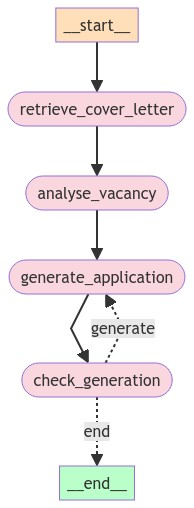

In [27]:
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import END, StateGraph

# Initialize the graph
work_flow = StateGraph(GraphState)


# Define the nodes
work_flow.add_node("retrieve_cover_letter", retrieve_cover_letter)  # retrieve cover letter
work_flow.add_node("analyse_vacancy", analyse_vacancy)  # analyse vacancy
work_flow.add_node("generate_application", generate_application)  # generation solution
work_flow.add_node("check_generation", check_generation)  # check generation

# Build graph
work_flow.set_entry_point("retrieve_cover_letter")
work_flow.add_edge("retrieve_cover_letter", "analyse_vacancy")
work_flow.add_edge("analyse_vacancy", "generate_application")
work_flow.add_edge("generate_application", "check_generation")
work_flow.add_conditional_edges(
    "check_generation",
    decide_to_finish,
    {
        "end": END,
        "generate": "generate_application",
    },
)

# Set up the memory and compile the graph
memory = SqliteSaver.from_conn_string(":memory:")
graph = work_flow.compile(checkpointer=memory)

# Display the graph
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception as e:
    print(f"Error displaying the graph: {e}")

In [99]:
_printed = set()
thread_id = str(uuid.uuid4())
config = {
    "configurable": {
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}

events = graph.stream({'messages': ['user', query_for_search], 'iterations': 0}, config=config, stream_mode='values')


for event in events:
    _print_event(event, _printed)




Engineering
In the platform area in Digital Architecture, Data and AI we lay the groundwork for other product teams to delivering accurate, available, and comprehensive data products to enable actionable insights. In addition to this we create trusted and curated enterprise data products that span the entire business of Vestas. This newly established department is an integral component of Vestas' innovative Digital Powerhouse. Our mission is to empower customers, partners, and colleagues to seamlessly discover, access, and connect essential information for informed decisions and impactful actions.
Digital Solutions & Development > Digital Solutions > Chapter - Data Engineering & Architecture
As a Data Engineer in the platform area, you will collaborate closely with colleagues both inside and outside of the platform area.
Your role involves leveraging a range of cloud technologies and tools tailored to the specific product you are working on. This encompasses working with technologies 

ValueError: Invalid input type <class 'dict'>. Must be a PromptValue, str, or list of BaseMessages.

In [ ]:
for event in events:
    _print_event(event)
    print("------")


In [ ]:



def validate_words(do_not_use_words, *args):
    false_count = 0
    true_count = 0

    forbidden_words_used = []

    for arg in args:
        words = arg.split()
        for word in words:
            if word in do_not_use_words:
                false_count += 1
                forbidden_words_used.append(word)
            else:
                true_count += 1
    
    # Return a tuple with the counts and the list of forbidden words used
    return true_count, false_count, forbidden_words_used

true_count, false_count, forbidden_words_used = validate_words(
    do_not_use_words,
    final_company_name, final_jobtitle, final_introduction, final_motivation, 
    final_skills, final_masters, final_bachelors,  final_continued_learning, 
    final_thank_you
)

# Print the results
print(f"Number of allowed words: {true_count}")
print(f"Number of forbidden words used: {false_count}")
print(f"Forbidden words used: {forbidden_words_used}")

Number of allowed words: 459
Number of forbidden words used: 2
Forbidden words used: ['seamlessly', 'enhancing']


In [ ]:
#some regex to remove characters that intervene with latex commands
def check_latex_safety(*args):
    # Dictionary to map LaTeX special characters to their safe equivalents
    replacements = {
        '\\': ' ',          # backslash to space
        '{': ' ',           # curly brace to space
        '}': ' ',           # curly brace to space
        '#': ' ',           # hash to space
        '%': ' ',           # percent to space
        '&': 'and',         # ampersand to 'and'
        '_': ' ',           # underscore to space
        '^': ' ',           # caret to space
        '~': ' ',           # tilde to space
        '$': 'dollars',     # dollar to space
        '/': ' ',           # slash to space
        '*': ' ',           # asterisk to space
        '-': ' '            # hyphen to space
    }
    
    # Regex pattern to match any LaTeX special character
    pattern = r'[\\{}#%&_^\~$\/\*\-]'
    
    true_count = 0
    false_count = 0

    # Function to replace matched characters
    def replace_match(match):
        return replacements[match.group(0)]
    
    # Process each input text
    results = []
    for text in args:
        if re.search(pattern, text):
            false_count += 1
            safe_text = re.sub(pattern, replace_match, text)
        else:
            true_count += 1
            safe_text = text
        results.append(safe_text)

    print(f"Number of safe texts: {true_count}")
    print(f"Number of modified texts: {false_count}")

    return results


# Example usage:

(final_company_name, 
 final_jobtitle, 
 final_introduction, 
 final_motivation, 
 final_skills, 
 final_masters, 
 final_bachelors, 
 final_continued_learning, 
 final_thank_you) = check_latex_safety(
                                        final_company_name, 
                                        final_jobtitle, 
                                        final_introduction, 
                                        final_motivation, 
                                        final_skills, 
                                        final_masters, 
                                        final_bachelors, 
                                        final_continued_learning, 
                                        final_thank_you)

# Directory where the variables.tex file will be saved
directory = 'companies_applied_for'

# Create the directory if it does not exist
if not os.path.exists(directory):
    os.makedirs(directory)

company_directory = os.path.join(directory, final_company_name)
if not os.path.exists(company_directory):
    os.makedirs(company_directory)

# Write these variables to a .tex file in the specified directory
resume_file_path = os.path.join(company_directory, final_company_name + '.tex')
with open(resume_file_path, 'w') as text_for_latex:
    text_for_latex.write(f"\\newcommand{{\\finalCompanyName}}{{{final_company_name}}}\n")
    text_for_latex.write(f"\\newcommand{{\\finalJobtitle}}{{{final_jobtitle}}}\n")
    text_for_latex.write(f"\\newcommand{{\\finalIntroduction}}{{{final_introduction}}}\n")
    text_for_latex.write(f"\\newcommand{{\\finalMotivation}}{{{final_motivation}}}\n")
    text_for_latex.write(f"\\newcommand{{\\finalSkills}}{{{final_skills}}}\n")
    text_for_latex.write(f"\\newcommand{{\\finalEducationMaster}}{{{final_masters}}}\n")
    text_for_latex.write(f"\\newcommand{{\\finalEducationBachelor}}{{{final_bachelors}}}\n")
    text_for_latex.write(f"\\newcommand{{\\finalContinuedLearning}}{{{final_continued_learning}}}\n")
    text_for_latex.write(f"\\newcommand{{\\finalThankYou}}{{{final_thank_you}}}\n")

latex_filename = f'JMangabat_{final_company_name}_{final_jobtitle}_{current_date}.tex'

latex_file_path = os.path.join(company_directory, latex_filename)

# Check if the file already exists and create a unique file name if it does
file_counter = 1
while os.path.exists(latex_file_path):
    new_file_name = f'JMangabat_{final_company_name}_{final_jobtitle}_{current_date}_{file_counter}.tex'
    latex_file_path = os.path.join(company_directory, new_file_name)
    file_counter += 1

template_tex = "main_setup.tex"

tex_content = tex_content = f"""
%----------------------------------------------------------------------------------------
% PACKAGES AND OTHER DOCUMENT CONFIGURATIONS
%----------------------------------------------------------------------------------------

\\documentclass{{article}}
% \\usepackage{{charter}} % Use the Charter font
\\usepackage{{graphicx}} % Required for including images
\\usepackage{{fancyhdr}} % Required for customizing headers and footers
\\usepackage{{setspace}} % Remove paragraph indentation
\\usepackage{{titlesec}} % Used to customize the \\section command
\\usepackage[
    a4paper, % Paper size
    top=15mm, % Top margin
    bottom=15mm, % Bottom margin
    left=15mm, % Left margin
    right=15mm, % Right margin
    % showframe % Uncomment to show frames around the margins for debugging purposes
]{{geometry}}

% \\setlength{{\\parindent}}{{0pt}} % Paragraph indentation
\\setlength{{\\parskip}}{{-0.7em}} % Vertical space between paragraphs

\\fancypagestyle{{firstpage}}{{%
    \\fancyhf{{}} % Clear default headers/footers
    \\renewcommand{{\\headrulewidth}}{{0pt}} % No header rule
    \\renewcommand{{\\footrulewidth}}{{1pt}} % Footer rule thickness
}}

\\fancypagestyle{{subsequentpages}}{{%
    \\fancyhf{{}} % Clear default headers/footers
    \\renewcommand{{\\headrulewidth}}{{1pt}} % Header rule thickness
    \\renewcommand{{\\footrulewidth}}{{1pt}} % Footer rule thickness
}}

\\input{{variables.tex}}

\\AtBeginDocument{{\\thispagestyle{{firstpage}}}} % Use the first page headers/footers style on the first page
\\pagestyle{{subsequentpages}} % Use the subsequent pages headers/footers style on subsequent pages
%----------------------------------------------------------------------------------------
%----------------------------------------------------------------------------------------
\\begin{{document}}
\\rule{{\\linewidth}}{{1pt}} % Horizontal rule

% Use the commands in your document
\\begin{{center}}
    Jannik M. B. Sørensen |
    Email: Mangabat93@gmail.com | 
    Odder, Denmark | Date
\\end{{center}}

\\subsection*{{\\finalJobtitle, \\finalCompanyName}}
    \\begin{{spacing}}{{1.2}}
        {{\\finalIntroduction}}
    \\end{{spacing}}
    \\vspace*{{0mm}}

\\subsection*{{Motivation}}
    \\begin{{spacing}}{{1.2}}
        {{\\finalMotivation}}
    \\end{{spacing}}
    \\vspace*{{0mm}}

\\subsection*{{Skills}}
    \\begin{{spacing}}{{1.2}}
        {{\\finalSkills}}
    \\end{{spacing}}
    \\vspace*{{0mm}}

\\subsection*{{Education}}
% Masters degree
    \\begin{{spacing}}{{1.2}}
        {{\\finalEducationMaster}}\\\\
        % Bachelors degree
        {{\\finalEducationBachelor}}
    \\end{{spacing}}
    \\vspace*{{0mm}}

\\subsection*{{Continued Learning}}
    \\begin{{spacing}}{{1.2}}
        {{\\finalContinuedLearning}}
    \\end{{spacing}}
    \\vspace*{{0mm}}

\\subsection*{{Thanks for your time}}
    \\begin{{spacing}}{{1.2}}
        {{\\finalThankYou}}\\\\        
    \\end{{spacing}}

\\noindent Kind regards,\\\\
    Jannik Mangabat
%----------------------------------------------------------------------------------------
% LETTER CONTENT
%----------------------------------------------------------------------------------------

\\end{{document}}
"""

with open(latex_file_path, 'w') as file:
    file.write(tex_content)

Number of safe texts: 4
Number of modified texts: 5
